# PROBLEMA DE NEGOCIO

## Una tienda online de moda,necesita impulsar su rendimiento utilizando sus datos de manera estratégica. 

## La tarea consiste en analizar los datos y ofrecer insights que guíen sus decisiones y respondan estas preguntas clave


### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

# 1. Importaciones

In [1]:
import  geobr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import matplotlib.image as image
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
import plotly.express as px
from PIL import Image  # Importamos PIL para trabajar con imágenes
import os  # Importamos os para trabajar con rutas de archivos y directorios
from matplotlib.colors import LinearSegmentedColormap
from urllib.request import urlretrieve
global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

# **2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---


## **2.1 Cargando las bases de datos**


Carguemos las bases datos a utilizar, en total serán 4 tablas.

In [2]:
df_itens_pedidos = pd.read_csv('"C:\Users\raulc\Downloads\itens_pedidos.csv"')
df_itens_pedidos.head()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [3]:
df_pedidos = pd.read_csv('"C:\Users\raulc\Downloads\pedidos.csv"')
df_pedidos.head()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [4]:
df_productos = pd.read_csv('"C:\Users\raulc\Downloads\productos.csv"')
df_productos.head()

,producto_id,producto,precio,marca,sku,condicion
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado


In [5]:
df_vendedores = pd.read_csv('"C:\Users\raulc\Downloads\vendedores.csv"')
df_vendedores.head()

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


In [6]:
df_pedidos.columns

Index(['pedido_id', 'producto_id', 'vendedor_id', 'fecha_compra', 'total'], dtype='object')

In [7]:
df_itens_pedidos.columns

Index(['id_recibo', 'producto_id', 'pedido_id', 'cantidad', 'valor_unitario',
       'valor_total', 'ciudad', 'costo_envio'],
      dtype='object')

## **2.2 Tratamiento de Datos**

In [8]:
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 

In [9]:
df_productos.isna().sum()

producto_id    0
producto       2
precio         0
marca          0
sku            2
condicion      0
dtype: int64

### Observaciones de los data frames:
+ Podemos observar que en data frame "df_pedidos" el valor de la columna fecha_de_compra es de tipo object, lo cual hay que convertila en tipo *datetime*.

+ Las primary key son: id_recibe,pedido_id,producto_id y vendedor_id

+ En la tabla productos tenemos que las columnas prducto y  sku tiene dos valores nulos.

+ Alguna de las llaves foráneas son: pedido_id,producto_id,vendedor_id


In [10]:
def preprocesamiento():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores

  #Lista de dataframes
  dataframes = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]

  #Eliminar registros nulos en primary keys o foreign keys
  for df in dataframes:

    #Eliminar valores nulos en la primera columna (que normalmente es la primary key)
    df.dropna(subset=[df.columns[0]], inplace=True)
    #Eliminar cualquier registro nulo
    df.dropna(inplace=True)
    #Eliminar registros duplicados
    df.drop_duplicates(inplace=True)

  #Modificar DTypes
  df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'])
  df_productos['sku'] = df_productos['sku'].astype(int)

In [11]:
preprocesamiento()
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int64         
 1   producto_id   24527 non-null  int64         
 2   vendedor_id   24527 non-null  int64         
 3 

## **2.3 Análisis Exploratorio (EDA)**

In [12]:
df_pedidos.describe(exclude="datetime")

,pedido_id,producto_id,vendedor_id,total
count,24527.000000,24527.000000,24527.000000,24527.000000
mean,69931.383088,44627.641171,2.975782,1867.490113
std,40560.769565,29347.824879,1.442412,3379.681887
min,1.000000,2706.000000,1.000000,45.000000
25%,34487.000000,17258.000000,2.000000,520.000000
50%,69945.000000,42913.000000,3.000000,1050.000000
75%,105355.000000,70673.000000,4.000000,1920.000000
max,139993.000000,100983.000000,6.000000,39000.000000


Podemos observar que el precio más bajo fue de $45 mientras que el más alto asciende a 3900

## Cantidad de productos diferentes

In [13]:
print(f"Existen {len(df_itens_pedidos['producto_id'].unique())} diferentes productos en df_itens_pedidos.")

Existen 205 diferentes productos en df_itens_pedidos.


Vamos a estudiar la distribución de nuestra variable valor_total del dataframe pedidos 

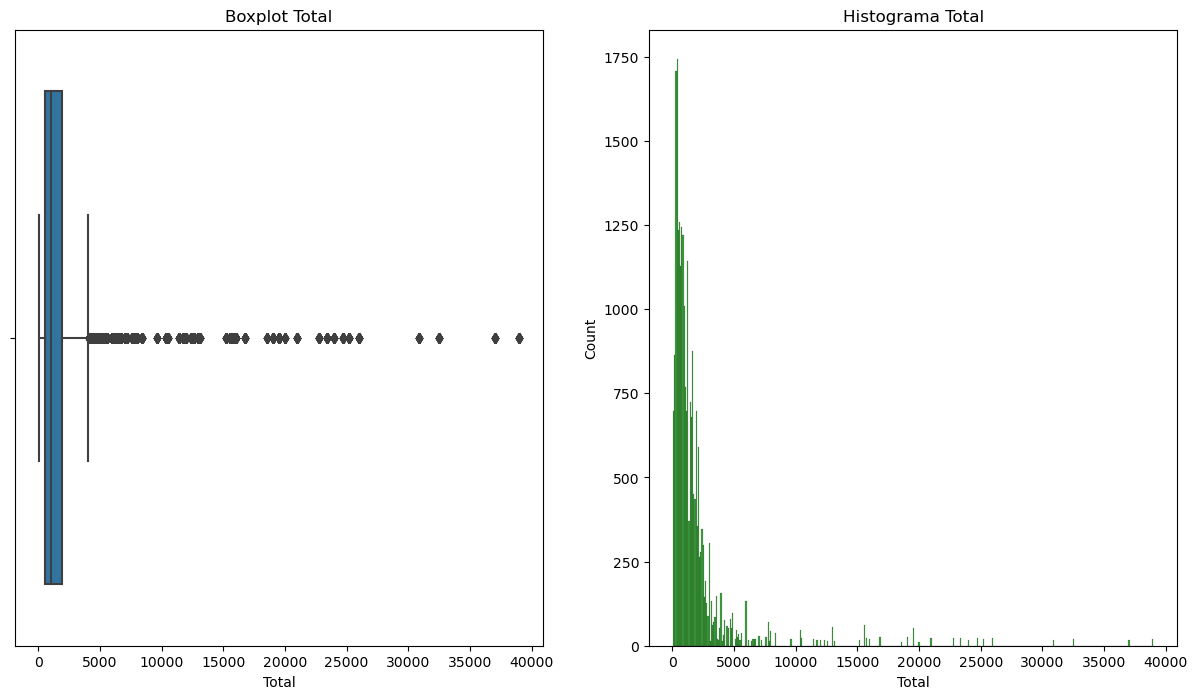

In [14]:
fig, axes = plt.subplots( ncols=2, figsize=(15, 8),)

sns.histplot(df_itens_pedidos,x="valor_total", color='green',ax=axes[1])
sns.boxplot(df_itens_pedidos,x="valor_total",ax=axes[0])

axes[0].set_title('Boxplot Total')
axes[1].set_title('Histograma Total')
axes[0].set_xlabel("Total")
axes[1].set_xlabel("Total")
plt.show()


- En nuestro box plot tenemos demasiados outliers pero esto corresponde a la diferencia de precio de productos ya que tenemos pruductos con valores demasiado altos.

- Mientras que el Histograma podemos observar que la mayor venta de productos se encuentra con un precio inferior a $5000.

## ¿Existen diferencias de precio en cuanto a la condición de la prenda?

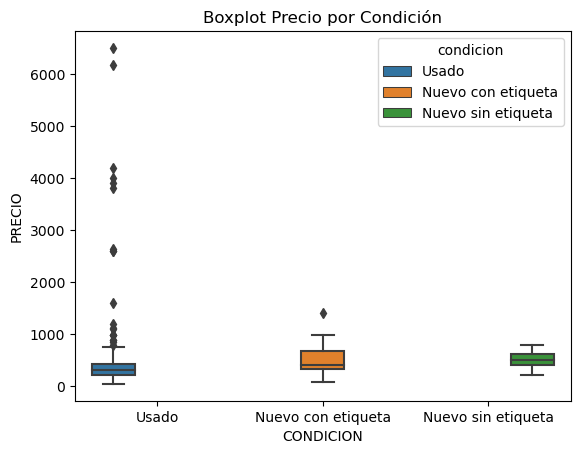

In [15]:
ax=sns.boxplot(df_productos,x="condicion",y="precio",hue="condicion")
ax.set(xlabel='CONDICION', ylabel='PRECIO')
ax.set_title("Boxplot Precio por Condición")
plt.show()

Como podemos ver la condición de usado tiene un precio inferior al de nuevo con etiqueta y nuevo sin etiqueta aunque existe una gran diferenciación de precio.


Los productos usados tienen una mayor variación en los precios, frente a la poca variación de los productos nuevos con etiqueta/sin etiqueta. Esto nos podría decir que los clientes esperan un rango de precios más consistente para los artículos.


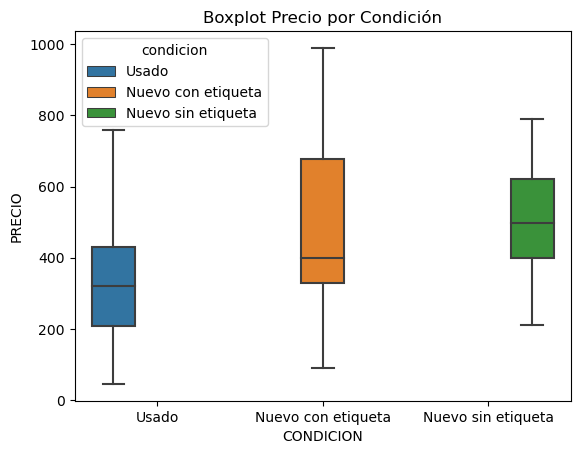

In [16]:
ax=sns.boxplot(df_productos,x="condicion",y="precio",hue="condicion",showfliers=False)
ax.set(xlabel='CONDICION', ylabel='PRECIO')
ax.set_title("Boxplot Precio por Condición")
plt.show()

Si no tenemos en cuenta los outliers, vemos como el precio mediano de nuevo sin etiqueta es el mayor, aunque vemos que el valor máximo de las prendas con etiquetas pueden llegar a los 1000 frente al valor máximo de 800 de las prendas nuevas sin etiquetas.

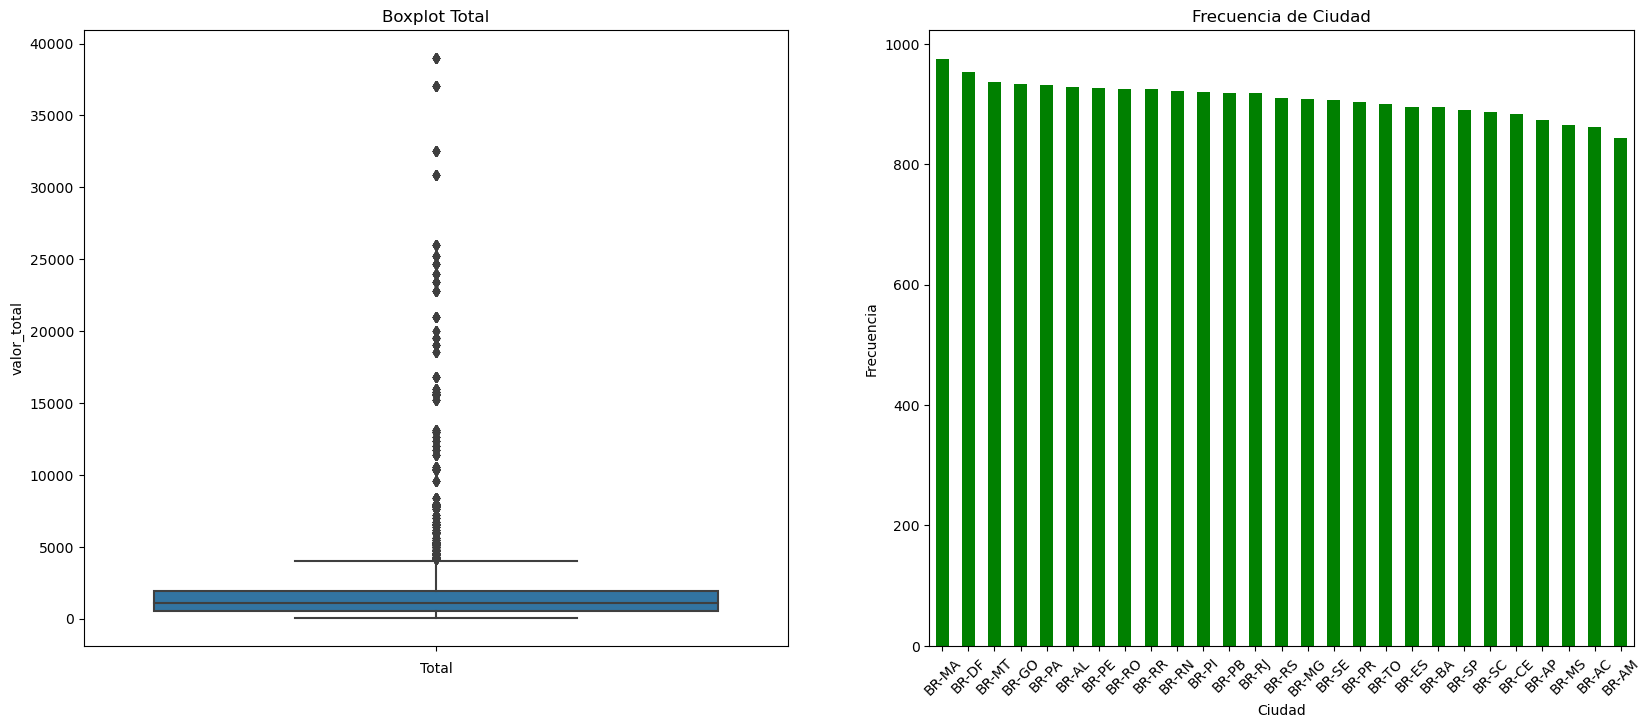

In [17]:
fig, axes = plt.subplots( ncols=2, figsize=(20, 8))

df_itens_pedidos["ciudad"].value_counts().plot(kind="bar",ax=axes[1],color="green")

sns.boxplot(df_itens_pedidos,y="valor_total",ax=axes[0])

axes[0].set_title('Boxplot Total')
axes[1].set_title('Frecuencia de Ciudad')
axes[0].set_xlabel("Total")
axes[1].set_xlabel("Ciudad")
axes[1].set_ylabel("Frecuencia")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.show()

En este gráfico podemos observar la frecuencia de cada ciudad donde más ventas se producen , donde vemos que existen un mayor número de items pedidos de las ciudades : MA;DF del país de BR (Brasil)

# ¿ Que podemos saber del coste de envío?

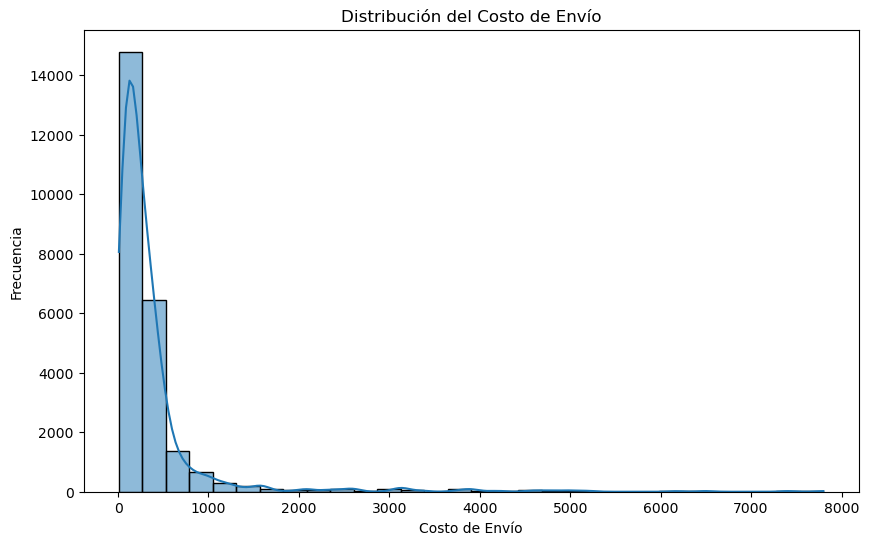

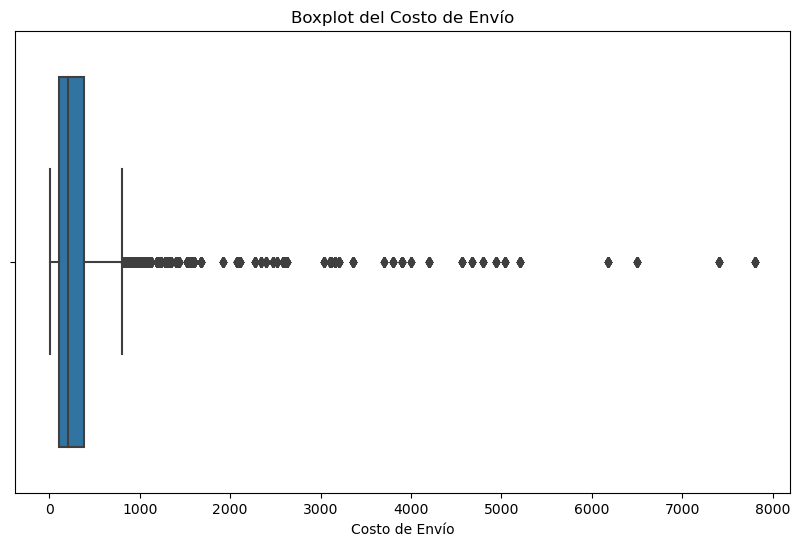

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df_itens_pedidos['costo_envio'], bins=30, kde=True)
plt.title('Distribución del Costo de Envío')
plt.xlabel('Costo de Envío')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de costo_envio
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_itens_pedidos['costo_envio'])
plt.title('Boxplot del Costo de Envío')
plt.xlabel('Costo de Envío')
plt.show()

Vemos como la mayor parte de los costos de envío se situan en una cantidad menor a 1000$ aunque existen muchos valores atípicos en los que se sitúan en el otro extremo.

Aunque podamos pensar que son outliers y que deberíamos hacer algo con ellos, debemos recordar que existen productos con precios(valores totales) también muy altos, por lo que podríamos pensar en que existe una tendencía positiva entre costo de envío y precio producto

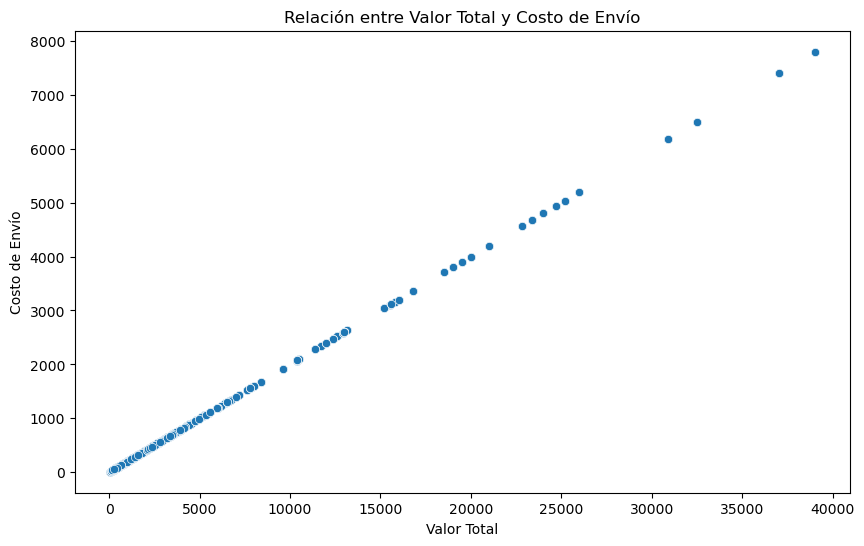

In [19]:
# Relación entre costo_envio y valor_total
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_itens_pedidos['valor_total'], y=df_itens_pedidos['costo_envio'])
plt.title('Relación entre Valor Total y Costo de Envío')
plt.xlabel('Valor Total')
plt.ylabel('Costo de Envío')
plt.show()

## Vamos analizar el coste de envío promedio por ciudad

ciudad
BR-AP    422.605269
BR-SC    416.750113
BR-CE    415.651416
BR-AL    410.025862
BR-PE    407.011219
BR-SP    394.497753
BR-PB    387.754466
BR-GO    380.012219
BR-MA    372.961807
BR-BA    369.831544
BR-PI    369.588248
BR-SE    369.154135
BR-AM    368.948043
BR-RR    364.802811
BR-MT    363.823693
BR-RJ    363.397386
BR-RS    362.782637
BR-RN    362.533550
BR-PR    362.155482
BR-MG    362.001322
BR-PA    360.836695
BR-TO    357.336819
BR-ES    356.389497
BR-RO    356.079784
BR-MS    352.945202
BR-DF    348.135992
BR-AC    327.677120
Name: costo_envio, dtype: float64


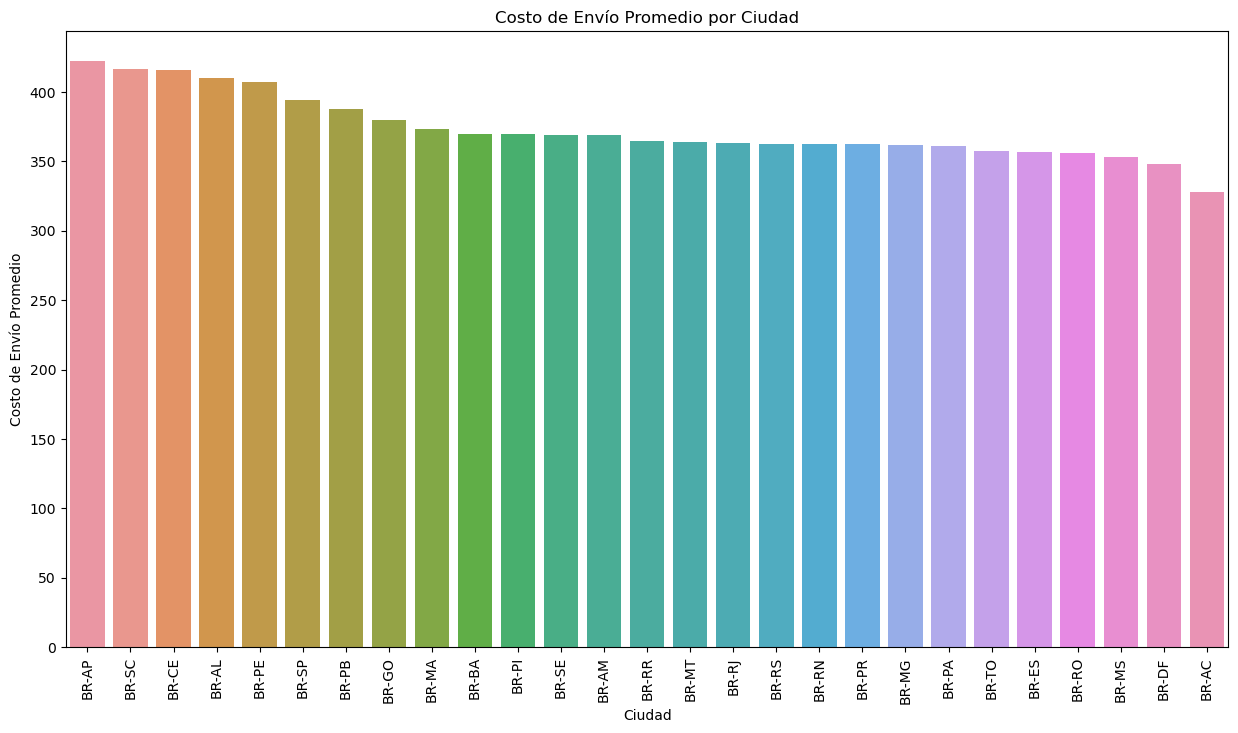

In [20]:
# Costo de envío promedio por ciudad
costo_envio_por_ciudad = df_itens_pedidos.groupby('ciudad')['costo_envio'].mean().sort_values(ascending=False)
print(costo_envio_por_ciudad)

# Visualización del costo de envío por ciudad
plt.figure(figsize=(15, 8))
sns.barplot(x=costo_envio_por_ciudad.index, y=costo_envio_por_ciudad.values)
plt.xticks(rotation=90)
plt.title('Costo de Envío Promedio por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Costo de Envío Promedio')
plt.show()


# **3. Preguntas y respuestas**


---




## **3.1 Creando la base de datos**

In [21]:
def crear_conexion():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database
  database=create_engine('sqlite:///:memory:')
  df_itens_pedidos.to_sql('itens_pedidos',database,index=False)
  df_pedidos.to_sql('pedidos',database,index=False)
  df_productos.to_sql('productos',database,index=False)
  df_vendedores.to_sql('vendedores',database,index=False)

In [22]:
crear_conexion()
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column)

Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'vendedor_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'fecha_compra', 'type': DATETIME(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'total', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


## **Pregunta 1: ¿Cual es el Top 5 productos más vendidos históricamente?**

In [23]:
query='''
    SELECT ip.producto_id,p.producto,p.marca,
    SUM(ip.valor_total) AS revenue, 
    SUM(ip.cantidad) AS cantidad_vendida
    FROM itens_pedidos  ip
    INNER JOIN productos  p ON p.producto_id=ip.producto_id
    GROUP BY ip.producto_id
    ORDER BY cantidad_vendida DESC
    LIMIT 5
    '''
df=pd.read_sql(sql=text(query),con=database.connect())


In [24]:
df

,producto_id,producto,marca,revenue,cantidad_vendida
0,32126,Saia Midi Cinto,Limone By Jade Seba,115290,549
1,13814,Vestido Nude Reta,Ellus,300850,547
2,47405,Blusa Manga Estampa,Animale,166160,536
3,33976,Camisa Xadrez Azul,Hollister,61320,511
4,53941,Cropped Escritas Pb,Linda de Morrer,142240,508


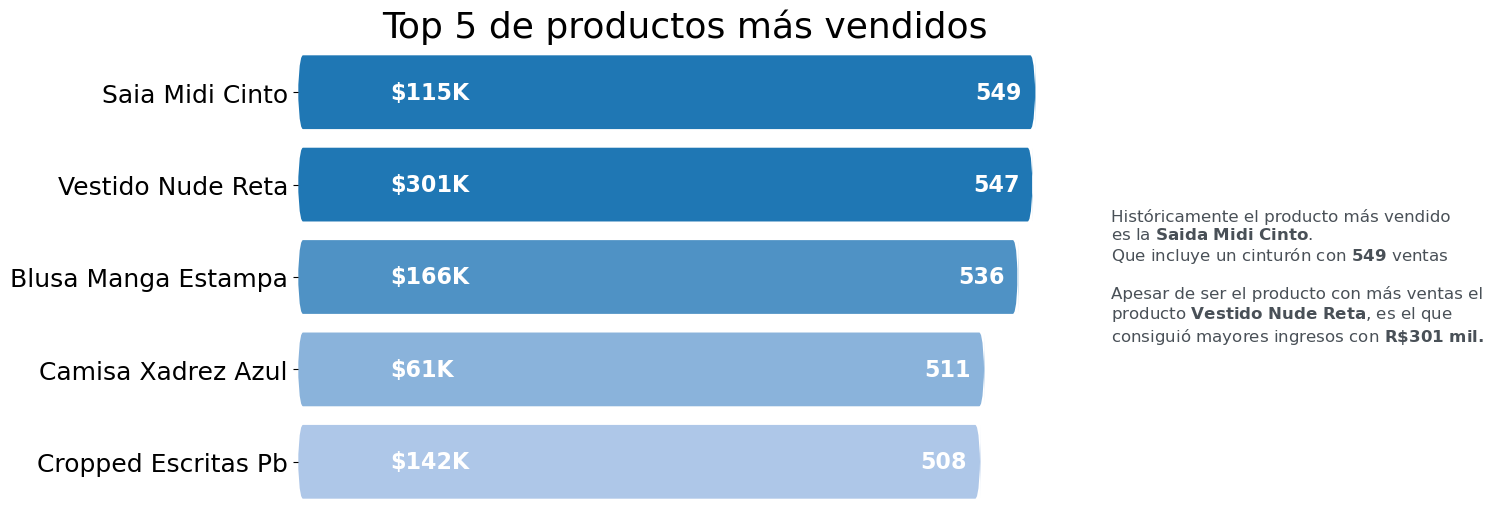

In [26]:
from segundo_notebook import grafico1
grafico1(df)

Pese a que el artículo Saia Midi Cinto es el más vendido, podríamos centrarnos en vender el vestido Nude Reta si nuestro objetivo es maximizar los ingresos , ya que existe una demanda muy parecida, pero los ingresos que generan el segundo vestido son muy superiores al primero

# ¿Que ropa tuvo más ventas en función de su condición?

In [31]:
crear_conexion()
query='''
    SELECT p.condicion,
    SUM(valor_total) AS total_vendido,
    SUM(cantidad) AS cantidad_vendida
    FROM productos p
    INNER JOIN itens_pedidos ip ON ip.producto_id=p.producto_id
    GROUP BY p.condicion
    '''
df_condicion=pd.read_sql(sql=text(query),con=database.connect())

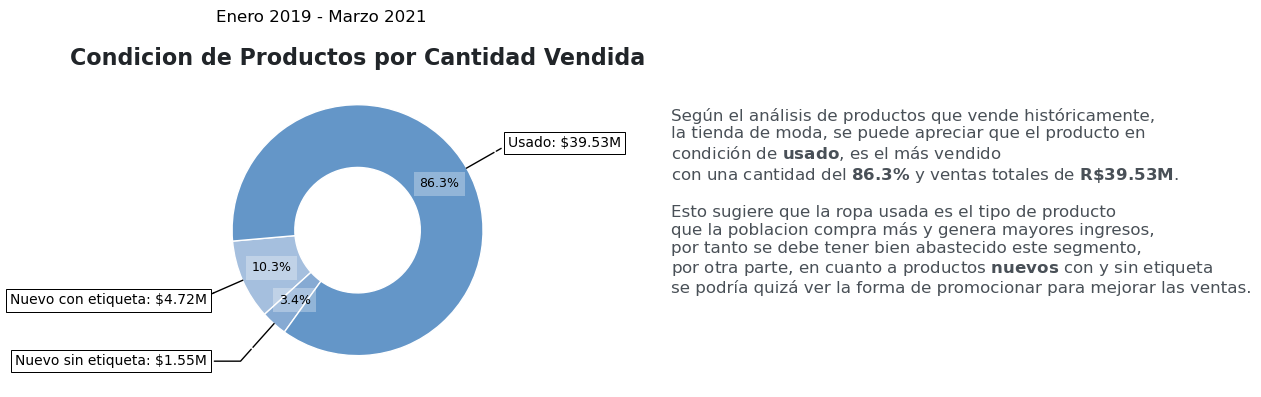

In [27]:
import import_ipynb 
from segundo_notebook import graf2 

graf2()

# Pregunta 2: ¿Cual es la evolución histórica de los ingresos netos?¶

In [33]:
query='''
    SELECT strftime('%Y-%m-%d',ped.fecha_compra) AS fecha_compra,
    SUM(total-costo_envio) AS total_ventas 
    FROM itens_pedidos  ip
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
    GROUP BY ped.fecha_compra
    ORDER BY fecha_compra ASC

    '''
df2=pd.read_sql(sql=text(query),con=database.connect())


In [34]:
query_marcas = """
    SELECT marca, SUM(cantidad * precio) AS ventas_totales
    FROM itens_pedidos ip
    INNER JOIN productos p ON ip.producto_id = p.producto_id
    INNER JOIN pedidos ped ON ip.pedido_id = ped.pedido_id
    WHERE strftime('%Y-%m-%d', ped.fecha_compra) = '2019-11-24'
    GROUP BY marca
    ORDER BY ventas_totales DESC;
"""
# Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df_marcas = pd.read_sql_query(query_marcas, database)

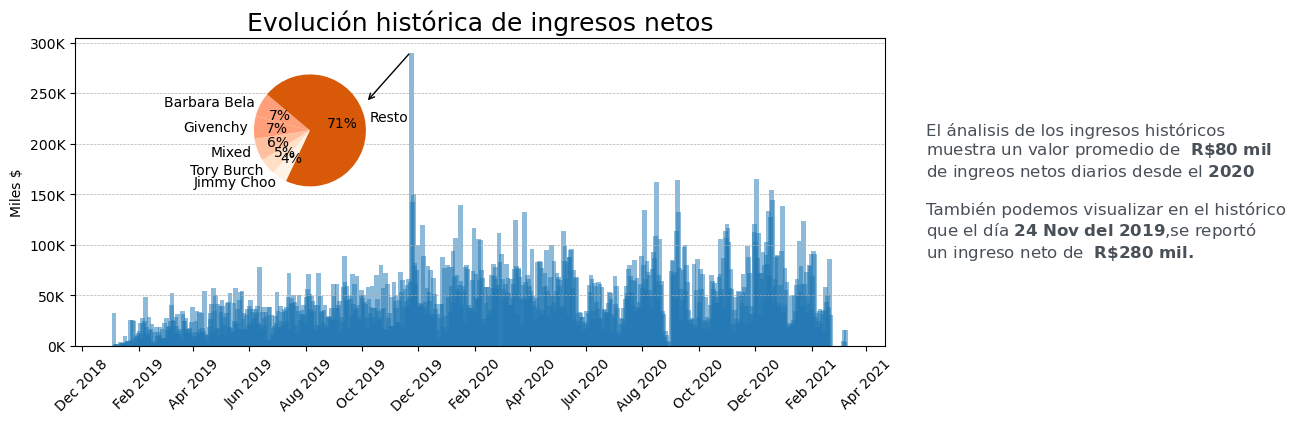

In [35]:
from segundo_notebook import grafico3  

grafico3()

## **Pregunta 2.1:¿Cuál es la causa del repunte del día 24 de Nov del 2019? (insight extra)**

In [37]:
query = '''
    SELECT strftime('%Y-%m-%d',ped.fecha_compra) AS fecha_compra,
           SUM(total-costo_envio) AS total_ventas
    FROM itens_pedidos ip
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
    GROUP BY ped.fecha_compra
    ORDER BY fecha_compra ASC
'''
df2=pd.read_sql(sql=text(query),con=database.connect())

In [38]:
query_df_total_cantidad = '''
    SELECT strftime('%Y-%m-%d', ped.fecha_compra) AS fecha_compra,
           SUM(total - costo_envio) AS total_ventas,
           SUM(ip.cantidad) AS total_cantidad
    FROM itens_pedidos ip
    INNER JOIN pedidos ped ON ped.pedido_id = ip.pedido_id
    GROUP BY ped.fecha_compra
    ORDER BY fecha_compra ASC
'''

# Ejecutar la consulta y guardar el resultado en un dataframe
df_total_cantidad=pd.read_sql(sql=text(query_df_total_cantidad),con=database.connect())

In [39]:
query_df_total_cantidad_dia_x = '''
    SELECT strftime('%Y-%m-%d', ped.fecha_compra) AS fecha_compra,
           SUM(total - costo_envio) AS total_ventas,
           SUM(ip.cantidad) AS total_cantidad
    FROM itens_pedidos ip
    INNER JOIN pedidos ped ON ped.pedido_id = ip.pedido_id
    WHERE strftime('%Y-%m-%d', ped.fecha_compra) = '2019-11-24'
    GROUP BY ped.fecha_compra
    ORDER BY fecha_compra ASC
'''
# Ejecutar la consulta y guardar el resultado en un dataframe
df_total_cantidad_dia_x = pd.read_sql(sql=text(query_df_total_cantidad_dia_x),con=database.connect())

In [40]:
# Marcas más vendidas en el día 2019-11-24
query_productos_5_caros = """
SELECT t.producto,
       t.precio,
       SUM(t.cantidad) AS cantidad_total,
       SUM(t.cantidad * t.precio) AS total_por_precio
FROM (
    SELECT p.producto_id,
           p.producto,
           p.precio,
           ip.cantidad
    FROM itens_pedidos ip
    INNER JOIN productos p ON ip.producto_id = p.producto_id
    INNER JOIN pedidos ped ON ip.pedido_id = ped.pedido_id
    WHERE strftime('%Y-%m-%d', ped.fecha_compra) = '2019-11-24'
    AND p.precio = (
        SELECT MAX(precio)
        FROM productos
        WHERE producto = p.producto
    )
) AS t
GROUP BY t.producto_id, t.producto, t.precio
ORDER BY precio DESC
LIMIT 5;
"""


query_vendedores="""
SELECT
    ven.nombre_vendedor,
    SUM(CASE WHEN DATE(ped.fecha_compra) = '2019-11-24' THEN ip.valor_total - ip.costo_envio ELSE 0 END) AS Total_neto
FROM
    itens_pedidos ip
    INNER JOIN pedidos ped ON ped.pedido_id = ip.pedido_id
    INNER JOIN vendedores ven ON ven.vendedor_id = ped.vendedor_id
GROUP BY
    ven.nombre_vendedor
LIMIT 5;
"""

In [41]:
df_query_top5 = pd.read_sql(sql=text(query_productos_5_caros),con=database.connect())

La media de ventas por vendedor es: 57992.159999999996


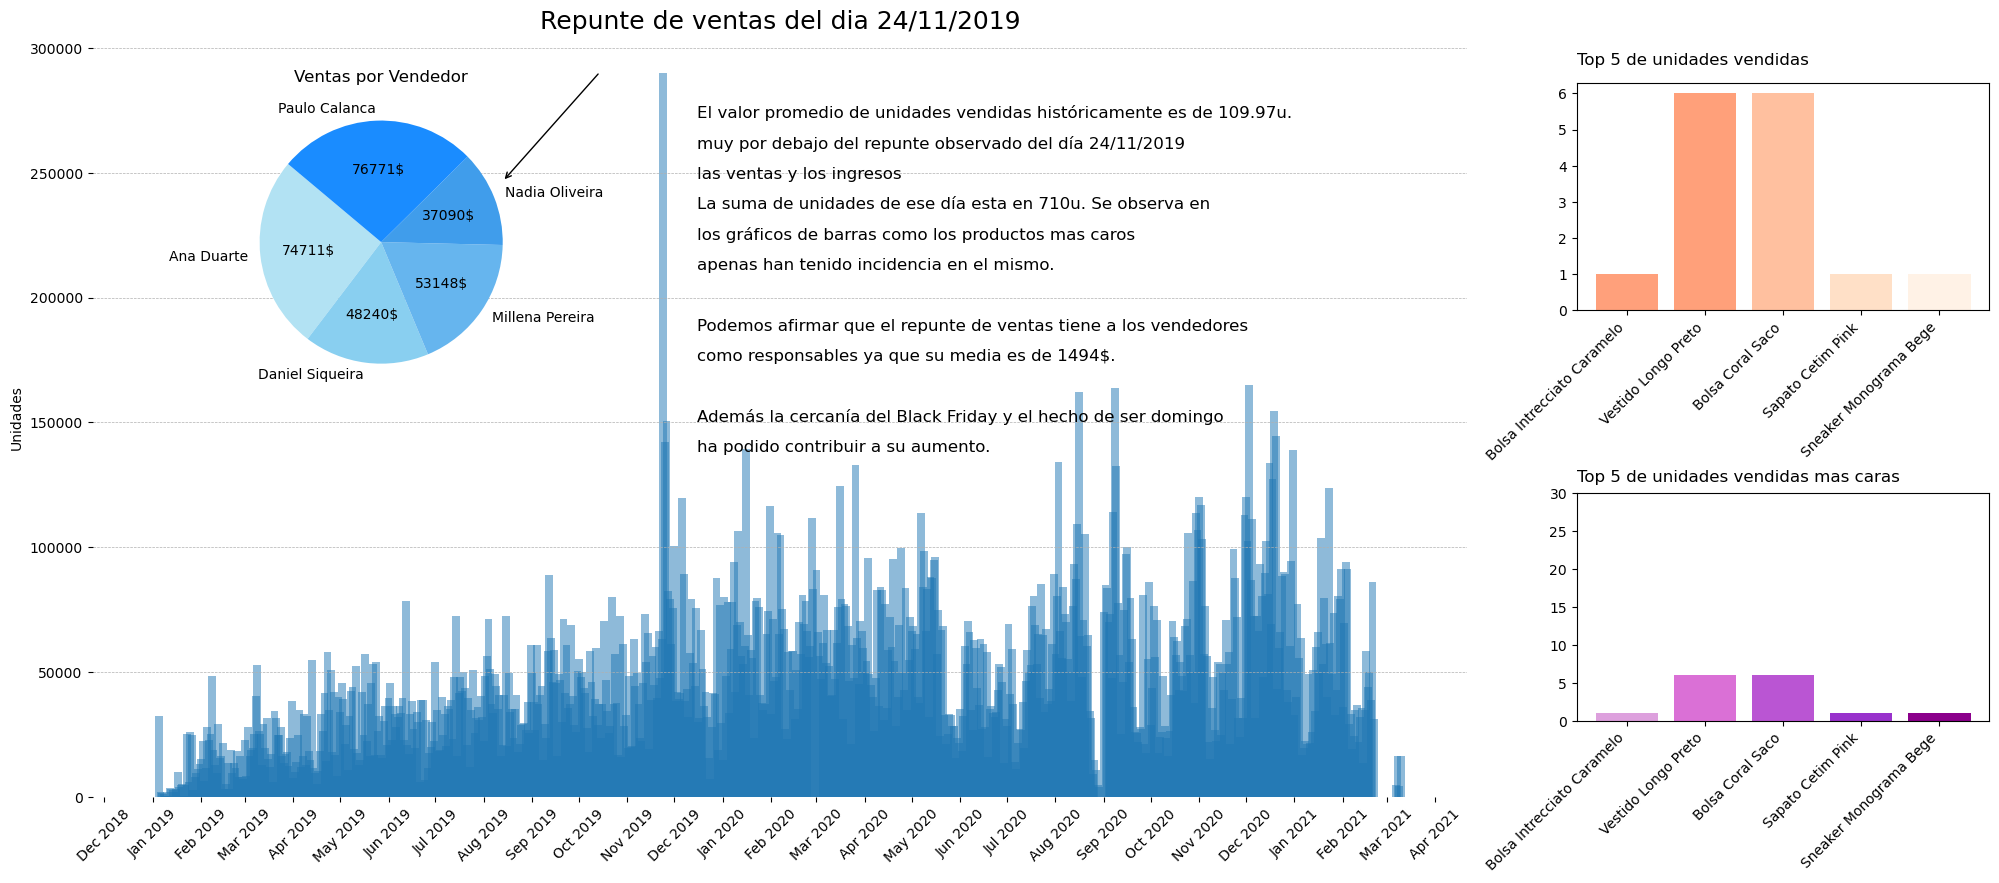

In [42]:
from segundo_notebook import grafico4

grafico4()

# Pico de ventas - Distribución geográfica

In [43]:
fecha_objetivo = '2019-11-24'
ventas_dia = df_pedidos[df_pedidos['fecha_compra'] == fecha_objetivo]

ventas_geo_dia = df_itens_pedidos[df_itens_pedidos['pedido_id'].isin(ventas_dia['pedido_id'])]
ventas_geo_dia = ventas_geo_dia.groupby('ciudad')['valor_total'].sum().reset_index().sort_values(by="valor_total",ascending=False)

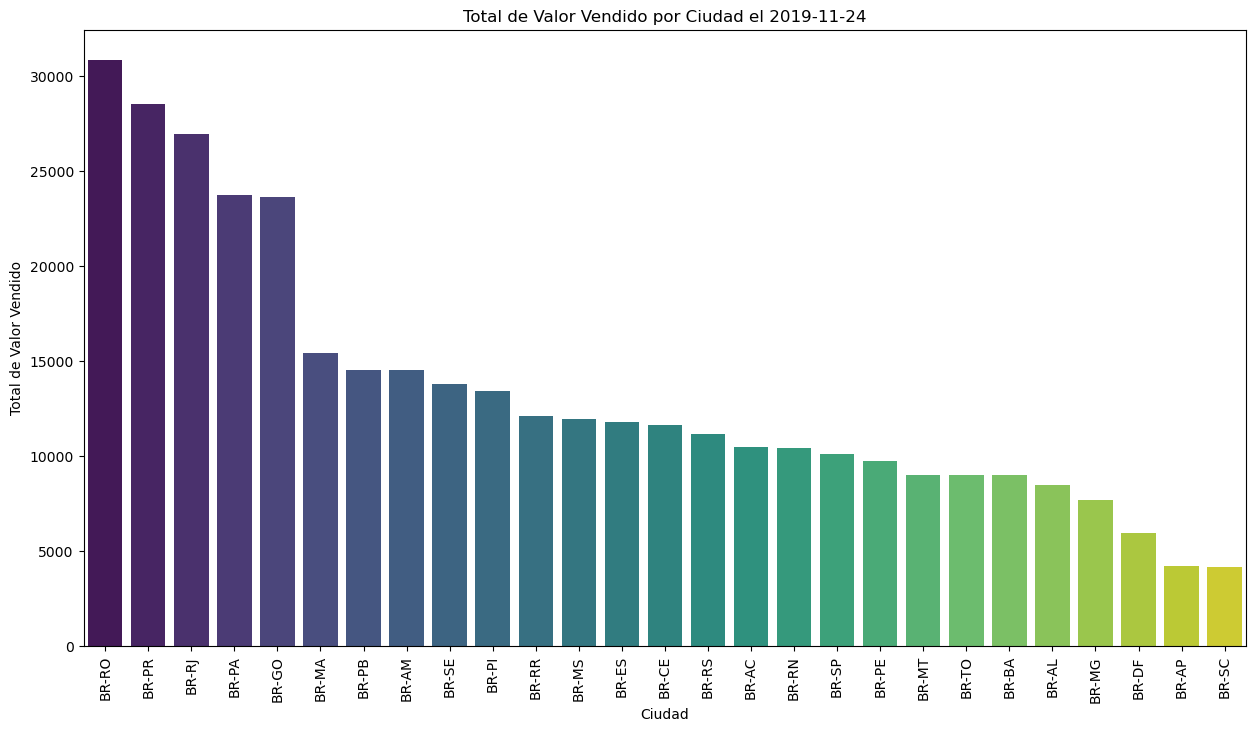

In [44]:
plt.figure(figsize=(15, 8))
sns.barplot(x='ciudad', y='valor_total', data=ventas_geo_dia, palette='viridis')
plt.xticks(rotation=90)
plt.title('Total de Valor Vendido por Ciudad el 2019-11-24')
plt.xlabel('Ciudad')
plt.ylabel('Total de Valor Vendido')
plt.show()

Vemos que el mayor revenue se alcanza en ciudades RO, PR,RJ,PA,GO,MA . 

## **Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

In [45]:
query='''
    SELECT ven.nombre_vendedor,
    
     
    SUM(CASE WHEN ped.fecha_compra >= "2019-01-01" AND ped.fecha_compra < "2020-01-01"THEN ip.valor_total - ip.costo_envio ELSE 0 END) AS "2019",
    SUM(CASE WHEN ped.fecha_compra >= "2020-01-01" AND ped.fecha_compra < "2021-01-01"THEN ip.valor_total - ip.costo_envio ELSE 0 END) AS "2020",
    SUM(CASE WHEN ped.fecha_compra >= "2021-01-01" AND ped.fecha_compra < "2022-01-01"THEN ip.valor_total - ip.costo_envio ELSE 0 END) AS "2021"
 
     FROM itens_pedidos  ip
   
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
    INNER JOIN vendedores ven ON ven.vendedor_id=ped.vendedor_id 

    GROUP BY ven.nombre_vendedor
    LIMIT 5
    '''

df3=pd.read_sql(sql=text(query),con=database.connect(),index_col="nombre_vendedor")

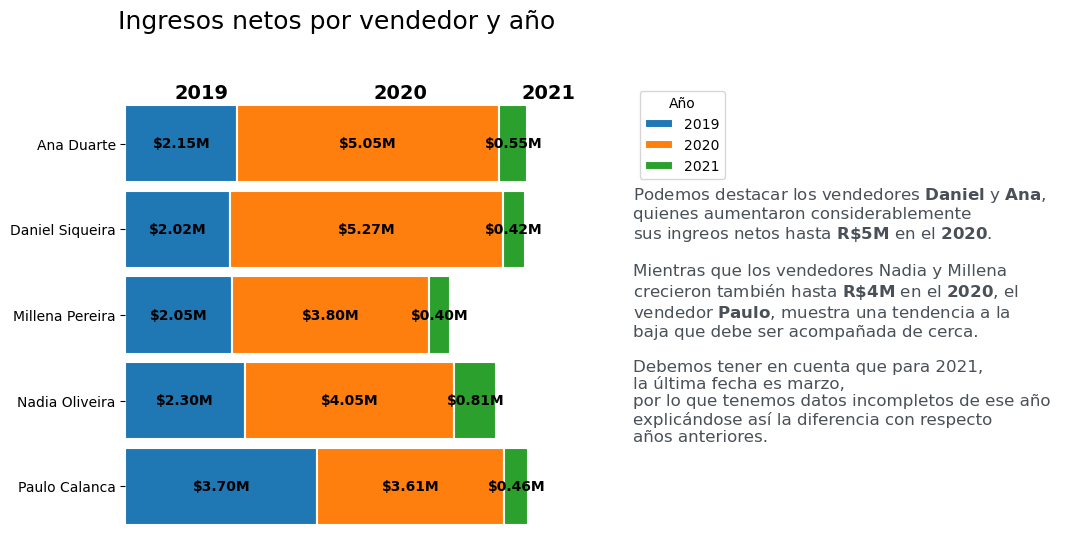

In [46]:
from segundo_notebook import grafico5  

grafico5()

## **Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [47]:
query = """
    SELECT ip.ciudad, SUM(ip.costo_envio) AS costos, SUM(p.total - ip.costo_envio) AS ingresos_netos
    FROM pedidos p
    INNER JOIN itens_pedidos ip ON p.pedido_id = ip.pedido_id
    GROUP BY ip.ciudad;
"""
#Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df4 = pd.read_sql_query(query, database)
df4['abbrev_state'] = df4['ciudad'].apply(lambda x: x.replace('BR-', ''))




In [48]:
#Seleccionar columnas de interes
df_2 = df4[["ingresos_netos", "abbrev_state"]]
df_2.head()

,ingresos_netos,abbrev_state
0,1128520.0,AC
1,1522016.0,AL
2,1244092.8,AM
3,1475737.6,AP
4,1322517.6,BA


In [49]:
df_3 = df4[["costos", "abbrev_state"]]
df_3.head()

,costos,abbrev_state
0,282130.0,AC
1,380504.0,AL
2,311023.2,AM
3,368934.4,AP
4,330629.4,BA


In [50]:
br_uf = geobr.read_state()
br_uf_d1 = br_uf.merge(df_2)
br_uf_d1 = br_uf_d1[["geometry", "ingresos_netos","abbrev_state"]]
br_uf_d1.head()

,geometry,ingresos_netos,abbrev_state
0,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...",1317495.2,RO
1,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...",1128520.0,AC
2,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...",1244092.8,AM
3,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...",1349770.4,RR
4,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...",1345199.2,PA


In [51]:

#Crear la geomtría 2
br_uf = geobr.read_state()
br_uf_d2 = br_uf.merge(df_3)
br_uf_d2 = br_uf_d2[["geometry", "costos","abbrev_state"]]
br_uf_d2.head()
     

,geometry,costos,abbrev_state
0,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...",329373.8,RO
1,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...",282130.0,AC
2,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...",311023.2,AM
3,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...",337442.6,RR
4,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...",336299.8,PA


(-76.24817529038594,
 -26.578218219857327,
 -35.70327738891226,
 7.223037194862763)

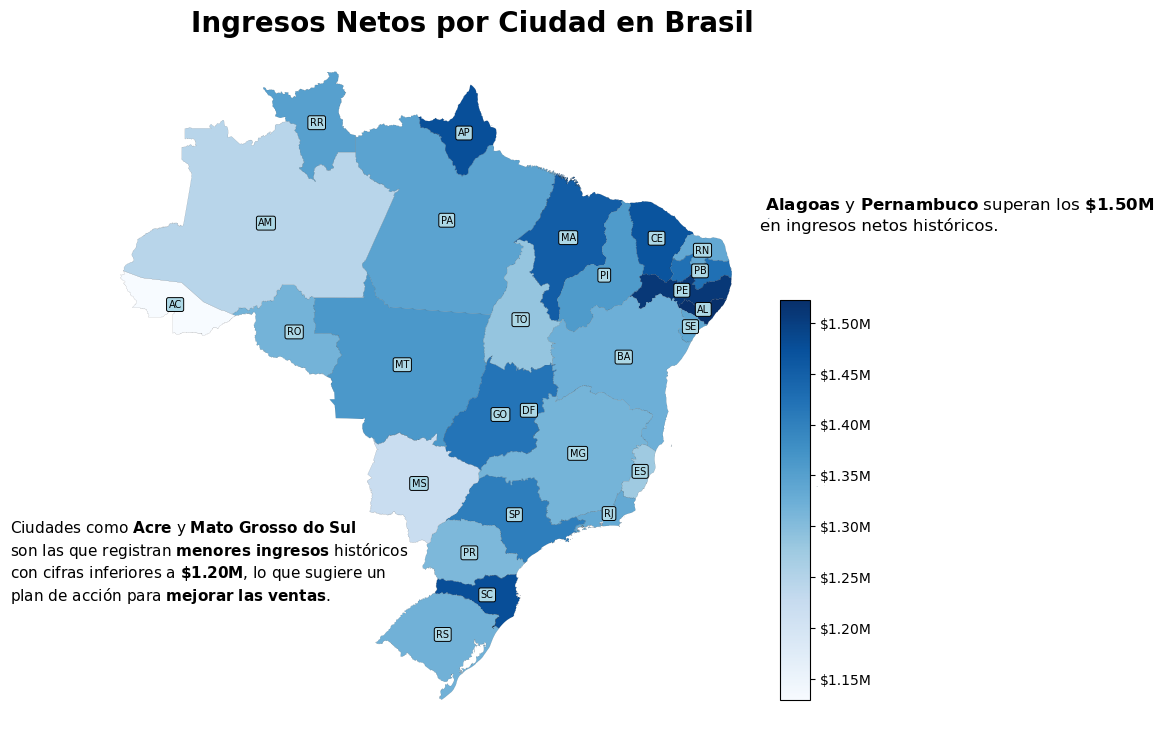

In [53]:
from segundo_notebook import grafico6  

grafico6()

## **Pregunta 5: ¿Cuáles son las ciudades que generaron menores ingresos?**

In [54]:
query='''
    SELECT ip.ciudad,
    SUM(total-costo_envio) AS ingresos_netos,
    SUBSTRING(ciudad,4,4) AS abbrev_state,
    SUM(cantidad) AS cantidad_vendida
 
    FROM itens_pedidos  ip
   
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
   

    GROUP BY ciudad
    ORDER BY ingresos_netos DESC
    
    '''

df_ex=pd.read_sql(sql=text(query),con=database.connect())
database.dispose()

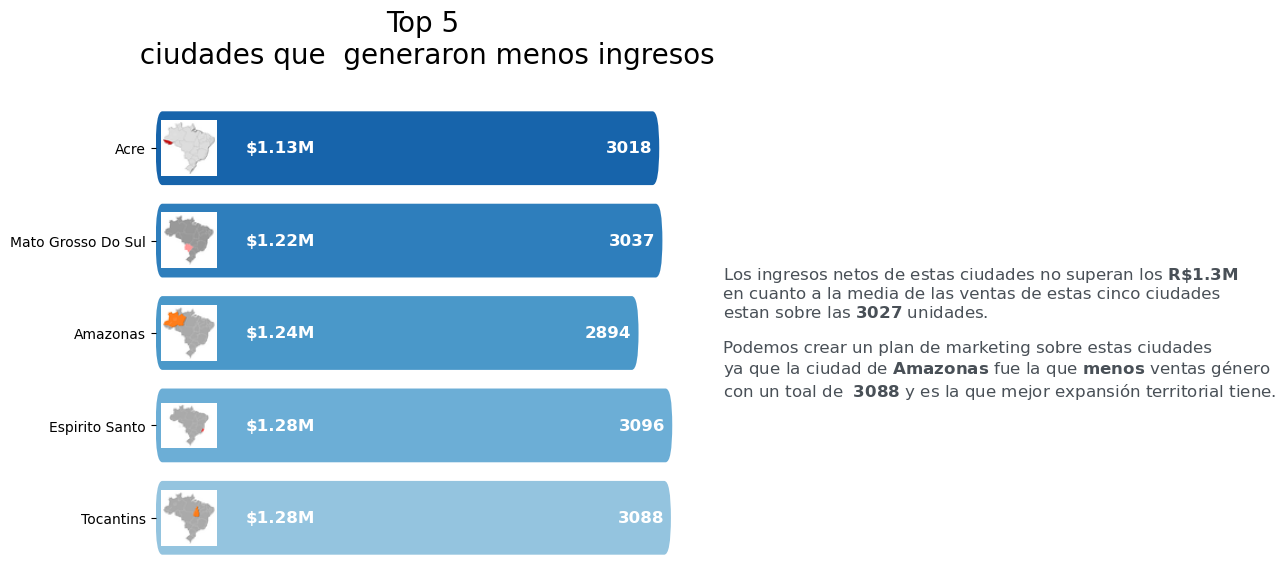

In [66]:
from segundo_notebook import grafico7  

grafico7()